## Model Training Work
Target variable: Passenger Fare Prediction

In [1]:
# Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date

# Set float display to avoid scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

# Wranings 
import warnings
warnings.filterwarnings('ignore')

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 3, Finished, Available, Finished)

### Read Data

In [2]:
# Read data 
train_df = pd.read_parquet("/lakehouse/default/Files/engineered/train_df6_base_pax_fare.parquet")
train_df.head()

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 4, Finished, Available, Finished)

,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,...,pickup_dayofmonth_26,pickup_dayofmonth_27,pickup_dayofmonth_28,pickup_dayofmonth_29,pickup_dayofmonth_30,time_of_day_Evening,time_of_day_Morning,time_of_day_Night,is_high_tip_1,is_night_ride_1
0,1.36,0.82,3.66,-0.36,0.67,0.83,-0.74,-0.31,-0.45,0.95,...,0,0,0,0,0,0,0,0,0,0
1,1.10,1.36,2.61,-0.36,-0.71,-0.63,-0.74,-0.31,-0.45,0.59,...,0,0,0,0,0,1,0,0,0,0
2,-1.06,-1.31,2.38,-0.36,-0.93,-0.88,-0.74,-0.31,-0.45,-1.44,...,0,0,0,0,0,0,1,0,0,0
3,0.55,0.20,3.51,-0.36,0.35,0.60,1.36,-0.31,1.68,0.21,...,0,0,0,0,0,0,0,1,0,1
4,-0.12,0.50,2.75,-0.36,-0.60,-0.46,-0.74,-0.31,-0.45,-0.00,...,0,0,0,0,0,1,0,0,0,0


In [3]:
# Shape 
train_df.shape

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 5, Finished, Available, Finished)

(2000000, 82)

In [4]:
# Info 
train_df.info()

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 6, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 82 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   trip_miles                float64
 1   trip_time                 float64
 2   base_passenger_fare       float64
 3   tolls                     float64
 4   bcf                       float64
 5   sales_tax                 float64
 6   congestion_surcharge      float64
 7   airport_fee               float64
 8   tips                      float64
 9   driver_pay                float64
 10  cbd_congestion_fee        float64
 11  driver_pay_per_mile       float64
 12  hvfhs_license_num_HV0005  int64  
 13  shared_request_flag_1     int64  
 14  shared_match_flag_1       int64  
 15  access_a_ride_flag_1      int64  
 16  wav_request_flag_1        int64  
 17  wav_match_flag_1          int64  
 18  pickup_hour_1             int64  
 19  pickup_hour_2             int64  
 20  pickup_hour_3           

### Correlations

In [31]:
# describe Continuous features 
train_df.select_dtypes('float64').describe()

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 33, Finished, Available, Finished)

,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,cbd_congestion_fee,driver_pay_per_mile
count,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00
mean,0.00,0.00,3.12,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00
std,1.00,1.00,0.65,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.59,-2.36,1.97,-0.36,-1.25,-2.15,-0.74,-0.31,-0.45,-1.85,-0.71,-1.70
25%,-0.81,-0.70,2.62,-0.36,-0.73,-0.70,-0.74,-0.31,-0.45,-0.76,-0.71,-0.70
50%,-0.17,0.02,3.04,-0.36,-0.28,-0.15,-0.74,-0.31,-0.45,-0.04,-0.71,-0.11
75%,0.69,0.71,3.54,-0.36,0.47,0.59,1.36,-0.31,-0.45,0.70,1.40,0.51
max,2.60,2.25,4.87,3.73,3.49,2.81,1.36,3.19,3.51,2.44,1.40,3.38


In [32]:
# Set continuous features 
continuous_features = train_df.select_dtypes('float64').columns

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 34, Finished, Available, Finished)

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 35, Finished, Available, Finished)

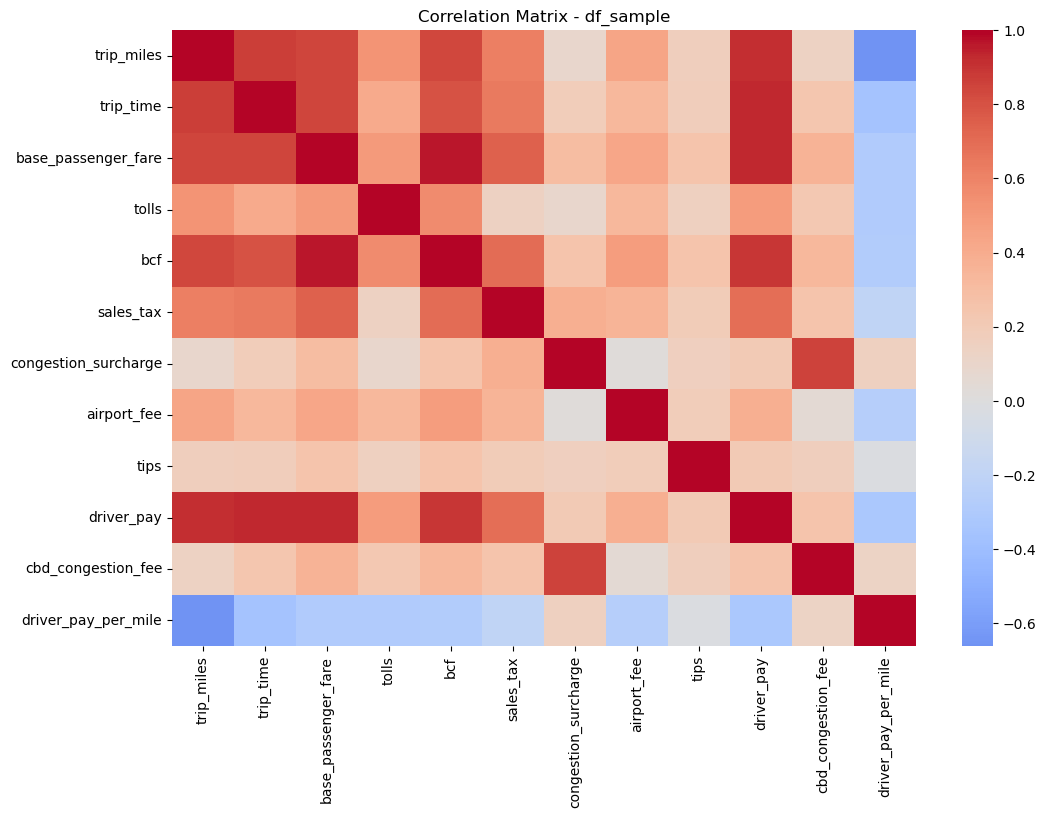

                      trip_miles  trip_time  base_passenger_fare  tolls   bcf  \
trip_miles                  1.00       0.86                 0.85   0.53  0.83   
trip_time                   0.86       1.00                 0.85   0.42  0.80   
base_passenger_fare         0.85       0.85                 1.00   0.50  0.96   
tolls                       0.53       0.42                 0.50   1.00  0.56   
bcf                         0.83       0.80                 0.96   0.56  1.00   
sales_tax                   0.62       0.65                 0.74   0.14  0.70   
congestion_surcharge        0.09       0.19                 0.31   0.09  0.26   
airport_fee                 0.44       0.33                 0.43   0.33  0.48   
tips                        0.17       0.17                 0.25   0.15  0.26   
driver_pay                  0.91       0.93                 0.93   0.48  0.89   
cbd_congestion_fee          0.14       0.24                 0.36   0.23  0.33   
driver_pay_per_mile        -

In [33]:
# calculate correlations only for numeric columns (continous only, not categorical)
corr_matrix = train_df.select_dtypes(include='float64').corr(numeric_only=True)

# heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix - df_sample")
plt.show()

# if you want to check only correlation with the target
print(corr_matrix)

### Selecting Features (X), Target (y)

In [8]:
# Columns 
train_df.columns

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 10, Finished, Available, Finished)

Index(['trip_miles', 'trip_time', 'base_passenger_fare', 'tolls', 'bcf',
       'sales_tax', 'congestion_surcharge', 'airport_fee', 'tips',
       'driver_pay', 'cbd_congestion_fee', 'driver_pay_per_mile',
       'hvfhs_license_num_HV0005', 'shared_request_flag_1',
       'shared_match_flag_1', 'access_a_ride_flag_1', 'wav_request_flag_1',
       'wav_match_flag_1', 'pickup_hour_1', 'pickup_hour_2', 'pickup_hour_3',
       'pickup_hour_4', 'pickup_hour_5', 'pickup_hour_6', 'pickup_hour_7',
       'pickup_hour_8', 'pickup_hour_9', 'pickup_hour_10', 'pickup_hour_11',
       'pickup_hour_12', 'pickup_hour_13', 'pickup_hour_14', 'pickup_hour_15',
       'pickup_hour_16', 'pickup_hour_17', 'pickup_hour_18', 'pickup_hour_19',
       'pickup_hour_20', 'pickup_hour_21', 'pickup_hour_22', 'pickup_hour_23',
       'pickup_dayofweek_1', 'pickup_dayofweek_2', 'pickup_dayofweek_3',
       'pickup_dayofweek_4', 'pickup_dayofweek_5', 'pickup_dayofweek_6',
       'is_weekend_1', 'pickup_dayofmonth_2',

In [9]:
# Target 
y = train_df['base_passenger_fare']

# Features (changes per modelling demands)
X = train_df[['trip_miles', 'driver_pay', 'shared_match_flag_1', 'bcf',
        'access_a_ride_flag_1', 'wav_match_flag_1', 'is_weekend_1', 
        'time_of_day_Evening', 'time_of_day_Morning', 'time_of_day_Night']]

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 11, Finished, Available, Finished)

In [10]:
# Shape
print ("Shape of X" , X.shape) 
print ("Shape of y" , y.shape)

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 12, Finished, Available, Finished)

Shape of X (2000000, 10)
Shape of y (2000000,)


### Train Test Split 

In [11]:
# Train - test split 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 13, Finished, Available, Finished)

In [12]:
# Shapes 
print ("Shape of X_train:" , X_train.shape)
print ("Shape of y_train:" , y_train.shape)
print ("Shape of X_test:" , X_test.shape)
print ("Shape of y_test:" , y_test.shape)

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 14, Finished, Available, Finished)

Shape of X_train: (1600000, 10)
Shape of y_train: (1600000,)
Shape of X_test: (400000, 10)
Shape of y_test: (400000,)


In [13]:
y_train

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 15, Finished, Available, Finished)

399734    3.25
1750629   4.18
1102528   4.09
1910924   2.54
790025    2.90
          ... 
259178    3.31
1414414   3.07
131932    2.98
671155    2.25
121958    2.89
Name: base_passenger_fare, Length: 1600000, dtype: float64

###  Baseline Model

#### VIF
Best on sample data

In [ ]:
# Sample
X_sample = X.sample(n=10000, random_state=100)
X_sample.head()

In [ ]:
# Caculating VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# features dataframe is 'X' (no traget variable)

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_sample.columns
    vif_data["VIF"] = [variance_inflation_factor(X_sample.values, i) for i in range(X_sample.shape[1])]
    return vif_data

# Example usage:
vif_df = calculate_vif(X)   # replace 'features' with your dataframe of independent variables
print(vif_df)

In [ ]:
# Results
display(vif_df)

#### LR Model (sklearn)

In [14]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 16, Finished, Available, Finished)

LinearRegression()

#### Evaluation

In [15]:
# Model Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 17, Finished, Available, Finished)

RMSE: 0.14
MAE: 0.10
R²: 0.95


#### Predictions

In [16]:
# predictions for training and test 
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 18, Finished, Available, Finished)

In [17]:
# Shape 
print("Shape of train predictions:" ,y_train_pred.shape ) 
print("Shape of test predictions:" ,y_test_pred.shape)

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 19, Finished, Available, Finished)

Shape of train predictions: (1600000,)
Shape of test predictions: (400000,)


In [18]:
y_train

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 20, Finished, Available, Finished)

399734    3.25
1750629   4.18
1102528   4.09
1910924   2.54
790025    2.90
          ... 
259178    3.31
1414414   3.07
131932    2.98
671155    2.25
121958    2.89
Name: base_passenger_fare, Length: 1600000, dtype: float64

In [19]:
y_train_pred

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 21, Finished, Available, Finished)

array([3.07367043, 4.09845394, 3.94322197, ..., 2.94723948, 2.27615522,
       2.77765521])

**Confirmation**: Train data split is 80% of train_df and Test data split is 20% of train_df

Also **note:** target variable base_passenger_fare was log-transformed in EDA steps and this needs to be reversed

In [20]:
# Get predictions to original scale (before log transformation)
y_train_pred_exp = np.expm1(y_train_pred)          # log(1+x)
y_test_pred_exp = np.expm1(y_test_pred)            # log(1+x)

# Set target variable (driver_pay) to original scale 
y_train_exp = np.expm1(y_train)
y_test_exp = np.expm1(y_test)

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 22, Finished, Available, Finished)

In [21]:
# Train results
train_results = pd.DataFrame({
    "base_fare": y_train_exp,
    "predicted_fare":y_train_pred_exp,
    "series": "train"}, index=y_train_exp.index)
train_results

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 23, Finished, Available, Finished)

,base_fare,predicted_fare,series
399734,24.85,20.62,train
1750629,64.45,59.25,train
1102528,58.57,50.58,train
1910924,11.67,12.17,train
790025,17.14,16.36,train
...,...,...,...
259178,26.49,19.64,train
1414414,20.45,18.07,train
131932,18.74,18.05,train
671155,8.46,8.74,train


In [22]:
# Test results
test_results = pd.DataFrame({
    "base_fare": y_test_exp,
    "predicted_fare": y_test_pred_exp,
    "series": "test"}, index=y_test_exp.index)
test_results

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 24, Finished, Available, Finished)

,base_fare,predicted_fare,series
1828401,8.97,9.44,test
1200071,14.28,13.36,test
194849,30.81,29.36,test
1629054,24.50,21.21,test
191144,129.90,172.40,test
...,...,...,...
1171220,55.53,54.83,test
1409796,18.81,16.13,test
1150185,54.47,53.37,test
1681689,38.95,39.22,test


In [23]:
# Vertically concatenate train and test series 
results_df = pd.concat([train_results, test_results])
results_df

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 25, Finished, Available, Finished)

,base_fare,predicted_fare,series
399734,24.85,20.62,train
1750629,64.45,59.25,train
1102528,58.57,50.58,train
1910924,11.67,12.17,train
790025,17.14,16.36,train
...,...,...,...
1171220,55.53,54.83,test
1409796,18.81,16.13,test
1150185,54.47,53.37,test
1681689,38.95,39.22,test


In [24]:
# Shape 
results_df.shape

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 26, Finished, Available, Finished)

(2000000, 3)

In [25]:
# Read original training data 
initial_df = pd.read_parquet("/lakehouse/default/Files/train/")
initial_df.head()

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 27, Finished, Available, Finished)

,hvfhs_license_num,pickup_datetime,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag,cbd_congestion_fee,week_number
11322195,HV0003,2025-06-18 12:40:39,10.95,1683,37.72,0.00,0.95,3.35,0.00,0.00,0.00,32.46,N,N,N,N,N,0.00,25
12984601,HV0003,2025-06-20 21:29:28,8.89,2445,12.59,0.00,0.32,1.12,0.00,0.00,0.00,25.17,Y,Y,N,N,N,0.00,25
5431662,HV0003,2025-06-09 10:31:29,1.15,395,9.82,0.00,0.24,0.87,0.00,0.00,0.00,5.61,N,N,N,N,N,0.00,24
15867325,HV0003,2025-06-25 02:08:11,5.74,1110,32.51,0.00,0.78,2.89,2.75,0.00,3.89,19.30,N,N,N,N,N,1.50,26
13701913,HV0003,2025-06-21 20:52:19,3.17,1360,14.68,0.00,0.36,1.30,0.00,0.00,0.00,16.53,Y,Y,N,N,N,0.00,25


In [26]:
# Reset index
initial_df = initial_df.reset_index(drop=True)

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 28, Finished, Available, Finished)

In [27]:
# final_df
final_df = initial_df.join(results_df)
display(final_df)

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 29, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, a1dc45a5-707e-46c1-bf14-b45b0146ef5b)

#### LR model (Statsmodel)
for better inference

In [28]:
import statsmodels.api as sm

# Suppose X_train, y_train are your features and target
# Add constant (intercept)
X_train_const = sm.add_constant(X_train)

# Fit OLS regression
model = sm.OLS(y_train, X_train_const).fit()

# Print full summary
print(model.summary())

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 30, Finished, Available, Finished)

                             OLS Regression Results                            
Dep. Variable:     base_passenger_fare   R-squared:                       0.954
Model:                             OLS   Adj. R-squared:                  0.954
Method:                  Least Squares   F-statistic:                 3.311e+06
Date:                 Wed, 24 Sep 2025   Prob (F-statistic):               0.00
Time:                         09:56:22   Log-Likelihood:             8.7551e+05
No. Observations:              1600000   AIC:                        -1.751e+06
Df Residuals:                  1599989   BIC:                        -1.751e+06
Df Model:                           10                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 

#### Save model to lakehouse 

In [29]:
## Saving Linear Regression model (1st run)
import os

# Define models folder inside Lakehouse Files
models_path = "/lakehouse/default/Files/models/"

# Create folder if it doesn't exist
os.makedirs(models_path, exist_ok=True)

# Save the model
import joblib
joblib.dump(lr, os.path.join(models_path, "lr_sklearn_base_pax_fare.pkl"))

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 31, Finished, Available, Finished)

['/lakehouse/default/Files/models/lr_sklearn_base_pax_fare.pkl']

In [30]:
# Save predictions to fabric warehouse 
spark.createDataFrame(final_df).write.format("delta").mode("overwrite").saveAsTable("trained_final_df_4fares")

StatementMeta(, 6fa7e78d-0fc5-4b68-96f3-34777eab45cd, 32, Finished, Available, Finished)